<a href="https://colab.research.google.com/github/Jared-Glenn/100-Days-of-Python/blob/main/Days%2076-100/078_nobel_prize_analysis/078_Nobel_Prize_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Context

### Introduction

On November 27, 1895, Alfred Nobel signed his last will in Paris. When it was opened after his death, the will caused a lot of controversy, as Nobel had left much of his wealth for the establishment of a prize.

Alfred Nobel dictates that his entire remaining estate should be used to endow “prizes to those who, during the preceding year, have conferred the greatest benefit to humankind”.

Every year the Nobel Prize is given to scientists and scholars in the categories chemistry, literature, physics, physiology or medicine, economics, and peace. 

<img src=https://i.imgur.com/36pCx5Q.jpg>

Let's see what patterns we can find in the data of the past Nobel laureates. What can we learn about the Nobel prize and our world more generally?

### Upgrade plotly (only Google Colab Notebook)

Google Colab may not be running the latest version of plotly. If you're working in Google Colab, uncomment the line below, run the cell, and restart your notebook server. 

In [54]:
# %pip install --upgrade plotly

In [90]:
# %pip install --upgrade geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 12.3 MB/s 
     |████████████████████████████████| 16.6 MB 130 kB/s 
     |████████████████████████████████| 7.8 MB 46.4 MB/s 


### Import Statements

In [166]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import geopandas as gpd
import datetime as dt

### Notebook Presentation

In [56]:
pd.options.display.float_format = '{:,.2f}'.format

### Read the Data

In [57]:
df_data = pd.read_csv('nobel_prize_data.csv')

Caveats: The exact birth dates for Michael Houghton, Venkatraman Ramakrishnan, and Nadia Murad are unknown. I've substituted them with mid-year estimate of July 2nd. 


# Data Exploration & Cleaning

**Challenge**: Preliminary data exploration. 
* What is the shape of `df_data`? How many rows and columns?
* What are the column names?
* In which year was the Nobel prize first awarded?
* Which year is the latest year included in the dataset?

In [58]:
print(f"The shape of the data is {df_data.shape}")
print(f'There are {df_data.shape[0]} rows and {df_data.shape[1]} columns in the dataset.')

The shape of the data is (962, 16)
There are 962 rows and 16 columns in the dataset.


In [59]:
print(f"The columns names are {df_data.columns}.")

The columns names are Index(['year', 'category', 'prize', 'motivation', 'prize_share',
       'laureate_type', 'full_name', 'birth_date', 'birth_city',
       'birth_country', 'birth_country_current', 'sex', 'organization_name',
       'organization_city', 'organization_country', 'ISO'],
      dtype='object').


In [60]:
print(f'The first Nobel Prize was awarded in {df_data["year"].min()}.')

The first Nobel Prize was awarded in 1901.


In [61]:
print(f'The most recent Nobel Prize in the dataset was awarded in {df_data["year"].max()}.')

The most recent Nobel Prize in the dataset was awarded in 2020.


**Challange**: 
* Are there any duplicate values in the dataset?
* Are there NaN values in the dataset?
* Which columns tend to have NaN values?
* How many NaN values are there per column? 
* Why do these columns have NaN values?  

### Check for Duplicates

In [62]:
print(f'There are duplicates in this dataset: {df_data.duplicated().any()}')

There are duplicates in this dataset: False


### Check for NaN Values

In [63]:
print(f'There are NaN values in this dataset:\n{df_data.isna().any()}')

There are NaN values in this dataset:
year                     False
category                 False
prize                    False
motivation                True
prize_share              False
laureate_type            False
full_name                False
birth_date                True
birth_city                True
birth_country             True
birth_country_current     True
sex                       True
organization_name         True
organization_city         True
organization_country      True
ISO                       True
dtype: bool


In [64]:
df_data.isna().sum()

year                       0
category                   0
prize                      0
motivation                88
prize_share                0
laureate_type              0
full_name                  0
birth_date                28
birth_city                31
birth_country             28
birth_country_current     28
sex                       28
organization_name        255
organization_city        255
organization_country     254
ISO                       28
dtype: int64

In [65]:
df_data.head()

,year,category,prize,motivation,prize_share,laureate_type,full_name,birth_date,birth_city,birth_country,birth_country_current,sex,organization_name,organization_city,organization_country,ISO
0,1901,Chemistry,The Nobel Prize in Chemistry 1901,"""in recognition of the extraordinary services ...",1/1,Individual,Jacobus Henricus van 't Hoff,1852-08-30,Rotterdam,Netherlands,Netherlands,Male,Berlin University,Berlin,Germany,NLD
1,1901,Literature,The Nobel Prize in Literature 1901,"""in special recognition of his poetic composit...",1/1,Individual,Sully Prudhomme,1839-03-16,Paris,France,France,Male,NaN,NaN,NaN,FRA
2,1901,Medicine,The Nobel Prize in Physiology or Medicine 1901,"""for his work on serum therapy, especially its...",1/1,Individual,Emil Adolf von Behring,1854-03-15,Hansdorf (Lawice),Prussia (Poland),Poland,Male,Marburg University,Marburg,Germany,POL
3,1901,Peace,The Nobel Peace Prize 1901,NaN,1/2,Individual,Frédéric Passy,1822-05-20,Paris,France,France,Male,NaN,NaN,NaN,FRA
4,1901,Peace,The Nobel Peace Prize 1901,NaN,1/2,Individual,Jean Henry Dunant,1828-05-08,Geneva,Switzerland,Switzerland,Male,NaN,NaN,NaN,CHE


The NaN values in this dataset seem to be because the winner was not a member of a applicable organization (such as a university). Many of the "motivation" cells are empty as well, I assume because no reason was given and/or recorded.

Personal information is also commonly missing.

### Type Conversions

**Challenge**: 
* Convert the `birth_date` column to Pandas `Datetime` objects
* Add a Column called `share_pct` which has the laureates' share as a percentage in the form of a floating-point number.

#### Convert Year and Birth Date to Datetime

In [66]:
df_data['birth_date'] = pd.to_datetime(df_data['birth_date'])
df_data.head()

,year,category,prize,motivation,prize_share,laureate_type,full_name,birth_date,birth_city,birth_country,birth_country_current,sex,organization_name,organization_city,organization_country,ISO
0,1901,Chemistry,The Nobel Prize in Chemistry 1901,"""in recognition of the extraordinary services ...",1/1,Individual,Jacobus Henricus van 't Hoff,1852-08-30,Rotterdam,Netherlands,Netherlands,Male,Berlin University,Berlin,Germany,NLD
1,1901,Literature,The Nobel Prize in Literature 1901,"""in special recognition of his poetic composit...",1/1,Individual,Sully Prudhomme,1839-03-16,Paris,France,France,Male,NaN,NaN,NaN,FRA
2,1901,Medicine,The Nobel Prize in Physiology or Medicine 1901,"""for his work on serum therapy, especially its...",1/1,Individual,Emil Adolf von Behring,1854-03-15,Hansdorf (Lawice),Prussia (Poland),Poland,Male,Marburg University,Marburg,Germany,POL
3,1901,Peace,The Nobel Peace Prize 1901,NaN,1/2,Individual,Frédéric Passy,1822-05-20,Paris,France,France,Male,NaN,NaN,NaN,FRA
4,1901,Peace,The Nobel Peace Prize 1901,NaN,1/2,Individual,Jean Henry Dunant,1828-05-08,Geneva,Switzerland,Switzerland,Male,NaN,NaN,NaN,CHE


#### Add a Column with the Prize Share as a Percentage

In [67]:
split = df_data['prize_share'].str.split('/')
x = split.str[0].astype(int)
y = split.str[1].astype(int)
df_data['share_pct'] = (x / y) * 100
df_data.head()

,year,category,prize,motivation,prize_share,laureate_type,full_name,birth_date,birth_city,birth_country,birth_country_current,sex,organization_name,organization_city,organization_country,ISO,share_pct
0,1901,Chemistry,The Nobel Prize in Chemistry 1901,"""in recognition of the extraordinary services ...",1/1,Individual,Jacobus Henricus van 't Hoff,1852-08-30,Rotterdam,Netherlands,Netherlands,Male,Berlin University,Berlin,Germany,NLD,100.00
1,1901,Literature,The Nobel Prize in Literature 1901,"""in special recognition of his poetic composit...",1/1,Individual,Sully Prudhomme,1839-03-16,Paris,France,France,Male,NaN,NaN,NaN,FRA,100.00
2,1901,Medicine,The Nobel Prize in Physiology or Medicine 1901,"""for his work on serum therapy, especially its...",1/1,Individual,Emil Adolf von Behring,1854-03-15,Hansdorf (Lawice),Prussia (Poland),Poland,Male,Marburg University,Marburg,Germany,POL,100.00
3,1901,Peace,The Nobel Peace Prize 1901,NaN,1/2,Individual,Frédéric Passy,1822-05-20,Paris,France,France,Male,NaN,NaN,NaN,FRA,50.00
4,1901,Peace,The Nobel Peace Prize 1901,NaN,1/2,Individual,Jean Henry Dunant,1828-05-08,Geneva,Switzerland,Switzerland,Male,NaN,NaN,NaN,CHE,50.00


In [68]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   year                   962 non-null    int64         
 1   category               962 non-null    object        
 2   prize                  962 non-null    object        
 3   motivation             874 non-null    object        
 4   prize_share            962 non-null    object        
 5   laureate_type          962 non-null    object        
 6   full_name              962 non-null    object        
 7   birth_date             934 non-null    datetime64[ns]
 8   birth_city             931 non-null    object        
 9   birth_country          934 non-null    object        
 10  birth_country_current  934 non-null    object        
 11  sex                    934 non-null    object        
 12  organization_name      707 non-null    object        
 13  organ

<h1>Three Questions Regarding this Dataset</h1>
<ol>
<li>Which category of prize is most likely to go to an individual?</li>
<li>Where were most prize winners born?</li>
<li>What is the smallest percentage of a prize someone has won?</li>
</ol>

# Plotly Donut Chart: Percentage of Male vs. Female Laureates

**Challenge**: Create a [donut chart using plotly](https://plotly.com/python/pie-charts/) which shows how many prizes went to men compared to how many prizes went to women. What percentage of all the prizes went to women?

In [69]:
fig = px.pie(df_data, names='sex', title="Nobel Winners by Sex", hole=0.6)
fig.show()

# Who were the first 3 Women to Win the Nobel Prize?

**Challenge**: 
* What are the names of the first 3 female Nobel laureates? 
  * Marie Curie
  * Baroness Bertha Sophie Felicita von Suttner
  *Selma Ottilia Lovisa Lagerlof
* What did the win the prize for? 
  * Physics
  * Peace
  * Literature
* What do you see in their `birth_country`? Were they part of an organisation?
  * Russian Empire (No Organization)
  * Austrian Empire (No Organization)
  * Sweden (No Organization)

In [70]:
df_data[df_data['sex'] == "Female"].head()

,year,category,prize,motivation,prize_share,laureate_type,full_name,birth_date,birth_city,birth_country,birth_country_current,sex,organization_name,organization_city,organization_country,ISO,share_pct
18,1903,Physics,The Nobel Prize in Physics 1903,"""in recognition of the extraordinary services ...",1/4,Individual,"Marie Curie, née Sklodowska",1867-11-07,Warsaw,Russian Empire (Poland),Poland,Female,NaN,NaN,NaN,POL,25.00
29,1905,Peace,The Nobel Peace Prize 1905,NaN,1/1,Individual,"Baroness Bertha Sophie Felicita von Suttner, n...",1843-06-09,Prague,Austrian Empire (Czech Republic),Czech Republic,Female,NaN,NaN,NaN,CZE,100.00
51,1909,Literature,The Nobel Prize in Literature 1909,"""in appreciation of the lofty idealism, vivid ...",1/1,Individual,Selma Ottilia Lovisa Lagerlöf,1858-11-20,Mårbacka,Sweden,Sweden,Female,NaN,NaN,NaN,SWE,100.00
62,1911,Chemistry,The Nobel Prize in Chemistry 1911,"""in recognition of her services to the advance...",1/1,Individual,"Marie Curie, née Sklodowska",1867-11-07,Warsaw,Russian Empire (Poland),Poland,Female,Sorbonne University,Paris,France,POL,100.00
128,1926,Literature,The Nobel Prize in Literature 1926,"""for her idealistically inspired writings whic...",1/1,Individual,Grazia Deledda,1871-09-27,"Nuoro, Sardinia",Italy,Italy,Female,NaN,NaN,NaN,ITA,100.00


# Find the Repeat Winners

**Challenge**: Did some people get a Nobel Prize more than once? If so, who were they? 

In [71]:
is_winner = df_data.duplicated(subset=['full_name'], keep=False)
multiple_winners = df_data[is_winner]
multiple_winners

,year,category,prize,motivation,prize_share,laureate_type,full_name,birth_date,birth_city,birth_country,birth_country_current,sex,organization_name,organization_city,organization_country,ISO,share_pct
18,1903,Physics,The Nobel Prize in Physics 1903,"""in recognition of the extraordinary services ...",1/4,Individual,"Marie Curie, née Sklodowska",1867-11-07,Warsaw,Russian Empire (Poland),Poland,Female,NaN,NaN,NaN,POL,25.00
62,1911,Chemistry,The Nobel Prize in Chemistry 1911,"""in recognition of her services to the advance...",1/1,Individual,"Marie Curie, née Sklodowska",1867-11-07,Warsaw,Russian Empire (Poland),Poland,Female,Sorbonne University,Paris,France,POL,100.00
89,1917,Peace,The Nobel Peace Prize 1917,NaN,1/1,Organization,Comité international de la Croix Rouge (Intern...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.00
215,1944,Peace,The Nobel Peace Prize 1944,NaN,1/1,Organization,Comité international de la Croix Rouge (Intern...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.00
278,1954,Chemistry,The Nobel Prize in Chemistry 1954,"""for his research into the nature of the chemi...",1/1,Individual,Linus Carl Pauling,1901-02-28,"Portland, OR",United States of America,United States of America,Male,California Institute of Technology (Caltech),"Pasadena, CA",United States of America,USA,100.00
283,1954,Peace,The Nobel Peace Prize 1954,NaN,1/1,Organization,Office of the United Nations High Commissioner...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.00
297,1956,Physics,The Nobel Prize in Physics 1956,"""for their researches on semiconductors and th...",1/3,Individual,John Bardeen,1908-05-23,"Madison, WI",United States of America,United States of America,Male,University of Illinois,"Urbana, IL",United States of America,USA,33.33
306,1958,Chemistry,The Nobel Prize in Chemistry 1958,"""for his work on the structure of proteins, es...",1/1,Individual,Frederick Sanger,1918-08-13,Rendcombe,United Kingdom,United Kingdom,Male,University of Cambridge,Cambridge,United Kingdom,GBR,100.00
340,1962,Peace,The Nobel Peace Prize 1962,NaN,1/1,Individual,Linus Carl Pauling,1901-02-28,"Portland, OR",United States of America,United States of America,Male,California Institute of Technology (Caltech),"Pasadena, CA",United States of America,USA,100.00
348,1963,Peace,The Nobel Peace Prize 1963,NaN,1/2,Organization,Comité international de la Croix Rouge (Intern...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.00


# Number of Prizes per Category

**Challenge**: 
* In how many categories are prizes awarded? 
* Create a plotly bar chart with the number of prizes awarded by category. 
* Use the color scale called `Aggrnyl` to colour the chart, but don't show a color axis.
* Which category has the most number of prizes awarded? 
* Which category has the fewest number of prizes awarded? 

In [72]:
df_data['category'].unique()

array(['Chemistry', 'Literature', 'Medicine', 'Peace', 'Physics',
       'Economics'], dtype=object)

In [73]:
prizes_per_category = df_data.category.value_counts()

fig = px.bar(
    x=prizes_per_category.index,
    y=prizes_per_category.values,
     title="Nobel Prizes by Category",
     color=prizes_per_category.values, 
     color_continuous_scale='Aggrnyl')

# Remove color scale.
# fig.update_coloraxes(showscale=False)

fig.update_layout(xaxis_title='Nobel Prize Category',
                  coloraxis_showscale=False,
                  yaxis_title='Number of Prizes')

fig.show()

**Challenge**: 
* When was the first prize in the field of Economics awarded?
* Who did the prize go to?

In [74]:
df_data[df_data['category'] == 'Economics'].sort_values('year')

,year,category,prize,motivation,prize_share,laureate_type,full_name,birth_date,birth_city,birth_country,birth_country_current,sex,organization_name,organization_city,organization_country,ISO,share_pct
393,1969,Economics,The Sveriges Riksbank Prize in Economic Scienc...,"""for having developed and applied dynamic mode...",1/2,Individual,Jan Tinbergen,1903-04-12,the Hague,Netherlands,Netherlands,Male,The Netherlands School of Economics,Rotterdam,Netherlands,NLD,50.00
394,1969,Economics,The Sveriges Riksbank Prize in Economic Scienc...,"""for having developed and applied dynamic mode...",1/2,Individual,Ragnar Frisch,1895-03-03,Oslo,Norway,Norway,Male,University of Oslo,Oslo,Norway,NOR,50.00
402,1970,Economics,The Sveriges Riksbank Prize in Economic Scienc...,"""for the scientific work through which he has ...",1/1,Individual,Paul A. Samuelson,1915-05-15,"Gary, IN",United States of America,United States of America,Male,Massachusetts Institute of Technology (MIT),"Cambridge, MA",United States of America,USA,100.00
411,1971,Economics,The Sveriges Riksbank Prize in Economic Scienc...,"""for his empirically founded interpretation of...",1/1,Individual,Simon Kuznets,1901-04-30,Pinsk,Russian Empire (Belarus),Belarus,Male,Harvard University,"Cambridge, MA",United States of America,BLR,100.00
419,1972,Economics,The Sveriges Riksbank Prize in Economic Scienc...,"""for their pioneering contributions to general...",1/2,Individual,John R. Hicks,1904-04-08,Warwick,United Kingdom,United Kingdom,Male,University of Oxford,Oxford,United Kingdom,GBR,50.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,2019,Economics,The Sveriges Riksbank Prize in Economic Scienc...,“for their experimental approach to alleviatin...,1/3,Individual,Abhijit Banerjee,1961-02-21,Mumbai,India,India,Male,Massachusetts Institute of Technology (MIT),"Cambridge, MA",United States of America,IND,33.33
940,2019,Economics,The Sveriges Riksbank Prize in Economic Scienc...,“for their experimental approach to alleviatin...,1/3,Individual,Esther Duflo,1972-10-25,Paris,France,France,Female,Massachusetts Institute of Technology (MIT),"Cambridge, MA",United States of America,FRA,33.33
941,2019,Economics,The Sveriges Riksbank Prize in Economic Scienc...,“for their experimental approach to alleviatin...,1/3,Individual,Michael Kremer,1964-11-12,"New York, NY",United States of America,United States of America,Male,Harvard University,"Cambridge, MA",United States of America,USA,33.33
952,2020,Economics,The Sveriges Riksbank Prize in Economic Scienc...,“for improvements to auction theory and invent...,1/2,Individual,Paul R. Milgrom,1948-04-20,"Detroit, MI",United States of America,United States of America,Male,Stanford University,"Stanford, CA",United States of America,USA,50.00


# Male and Female Winners by Category

**Challenge**: Create a [plotly bar chart](https://plotly.com/python/bar-charts/) that shows the split between men and women by category. 
* Hover over the bar chart. How many prizes went to women in Literature compared to Physics?

<img src=https://i.imgur.com/od8TfOp.png width=650>

In [75]:
fig_men_women = df_data.groupby(['category', 'sex'],
                                as_index=False).agg({'prize': pd.Series.count})
fig_men_women.sort_values('prize', ascending=False, inplace=True)

fig_men_women

,category,sex,prize
11,Physics,Male,212
7,Medicine,Male,210
1,Chemistry,Male,179
5,Literature,Male,101
9,Peace,Male,90
3,Economics,Male,84
8,Peace,Female,17
4,Literature,Female,16
6,Medicine,Female,12
0,Chemistry,Female,7


In [76]:
v_bar_split = px.bar(x=fig_men_women.category,
    y=fig_men_women.prize,
     title="Nobel Prizes by Category",
     color=fig_men_women.sex,)

# Remove color scale.
# fig.update_coloraxes(showscale=False)

v_bar_split.update_layout(xaxis_title='Nobel Prize Category',
                  coloraxis_showscale=False,
                  yaxis_title='Number of Prizes')

v_bar_split.show()

# Number of Prizes Awarded Over Time

**Challenge**: Are more prizes awarded recently than when the prize was first created? Show the trend in awards visually. 
* Count the number of prizes awarded every year. 
* Create a 5 year rolling average of the number of prizes (Hint: see previous lessons analysing Google Trends).
* Using Matplotlib superimpose the rolling average on a scatter plot.
* Show a tick mark on the x-axis for every 5 years from 1900 to 2020. (Hint: you'll need to use NumPy). 

<img src=https://i.imgur.com/4jqYuWC.png width=650>

* Use the [named colours](https://matplotlib.org/3.1.0/gallery/color/named_colors.html) to draw the data points in `dogerblue` while the rolling average is coloured in `crimson`. 

<img src=https://i.imgur.com/u3RlcJn.png width=350>

* Looking at the chart, did the first and second world wars have an impact on the number of prizes being given out? 
* What could be the reason for the trend in the chart?


In [77]:
fig_year = df_data.groupby(['year'],
                                as_index=False).agg({'prize': pd.Series.count})
fig_year.sort_values('year', ascending=False, inplace=True)

fig_year

,year,prize
116,2020,12
115,2019,14
114,2018,13
113,2017,12
112,2016,11
...,...,...
4,1905,5
3,1904,6
2,1903,7
1,1902,7


In [78]:
df_roll = fig_year['prize'].rolling(window=6).mean()
df_roll.head(10)

116     NaN
115     NaN
114     NaN
113     NaN
112     NaN
111   12.17
110   12.33
109   12.17
108   11.67
107   11.83
Name: prize, dtype: float64

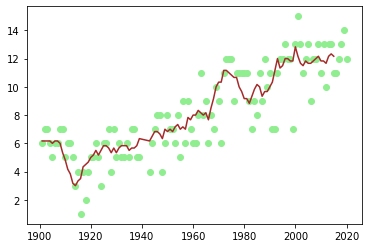

In [79]:
plt.scatter(fig_year['year'], fig_year['prize'], color="lightgreen")
plt.plot(fig_year['year'], df_roll, color="brown")

plt.show()

The first World War seems to have significantly decreased the number of Nobel Prizes issued. This is likely due to how new the prize was on the backdrop of the world seeming to fall apart. It likely wasn't allowed to flourish in that environment.

During the second World War, though, it seems to have been established enough to be unaffected by the war, and growth continued. By then, the honor of the prize probably gained them goodwill on both sides of the conflict, allowing for a slight increase in the number of prizes given.

# Are More Prizes Shared Than Before?

**Challenge**: Investigate if more prizes are shared than before. 

* Calculate the average prize share of the winners on a year by year basis.
* Calculate the 5 year rolling average of the percentage share.
* Copy-paste the cell from the chart you created above.
* Modify the code to add a secondary axis to your Matplotlib chart.
* Plot the rolling average of the prize share on this chart. 
* See if you can invert the secondary y-axis to make the relationship even more clear. 

In [80]:
df_prize_share = df_data.groupby(['year'],
                                as_index=False).agg({'share_pct': pd.Series.mean})
df_prize_share.sort_values('year', ascending=False, inplace=True)

df_prize_share

,year,share_pct
116,2020,50.00
115,2019,42.86
114,2018,46.15
113,2017,50.00
112,2016,54.55
...,...,...
4,1905,100.00
3,1904,83.33
2,1903,71.43
1,1902,71.43


In [81]:
df_prize_roll = df_prize_share['share_pct'].rolling(window=6).mean()
df_prize_roll.head(10)

116     NaN
115     NaN
114     NaN
113     NaN
112     NaN
111   49.68
110   49.04
109   49.59
108   51.90
107   51.26
Name: share_pct, dtype: float64

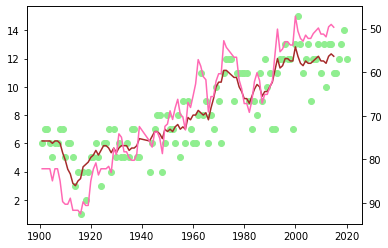

In [82]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.scatter(fig_year['year'], fig_year['prize'], color="lightgreen")
ax1.plot(fig_year['year'], df_roll, color="brown")
ax2.plot(df_prize_share['year'], df_prize_roll, color="hotpink")
ax2.invert_yaxis()

plt.show()

# The Countries with the Most Nobel Prizes

**Challenge**: 
* Create a Pandas DataFrame called `top20_countries` that has the two columns. The `prize` column should contain the total number of prizes won. 

<img src=https://i.imgur.com/6HM8rfB.png width=350>

* Is it best to use `birth_country`, `birth_country_current` or `organization_country`? 
* What are some potential problems when using `birth_country` or any of the others? Which column is the least problematic? 
* Then use plotly to create a horizontal bar chart showing the number of prizes won by each country. Here's what you're after:

<img src=https://i.imgur.com/agcJdRS.png width=750>

* What is the ranking for the top 20 countries in terms of the number of prizes?

Every way of representing this data comes with problems and possible misconceptions. I believe the least problematic method is to use the birth country with the current name. Since many places change names frequently, this will help the data present useful information.

Neither birth country nor the organization country guarantees that the work was done in the given country, but the birth country is unlikely to run into the problems of an organization that may concentrate prize winners in a single world-wide organization's home country.

In [83]:
df_data.columns

Index(['year', 'category', 'prize', 'motivation', 'prize_share',
       'laureate_type', 'full_name', 'birth_date', 'birth_city',
       'birth_country', 'birth_country_current', 'sex', 'organization_name',
       'organization_city', 'organization_country', 'ISO', 'share_pct'],
      dtype='object')

In [84]:
df_country = df_data.groupby(['birth_country_current'],
                                as_index=False).agg({'prize': pd.Series.count})
df_country.sort_values('prize', ascending=False, inplace=True)

df_country

,birth_country_current,prize
74,United States of America,281
73,United Kingdom,105
26,Germany,84
25,France,57
67,Sweden,29
...,...,...
32,Iceland,1
47,Madagascar,1
34,Indonesia,1
36,Iraq,1


<BarContainer object of 79 artists>

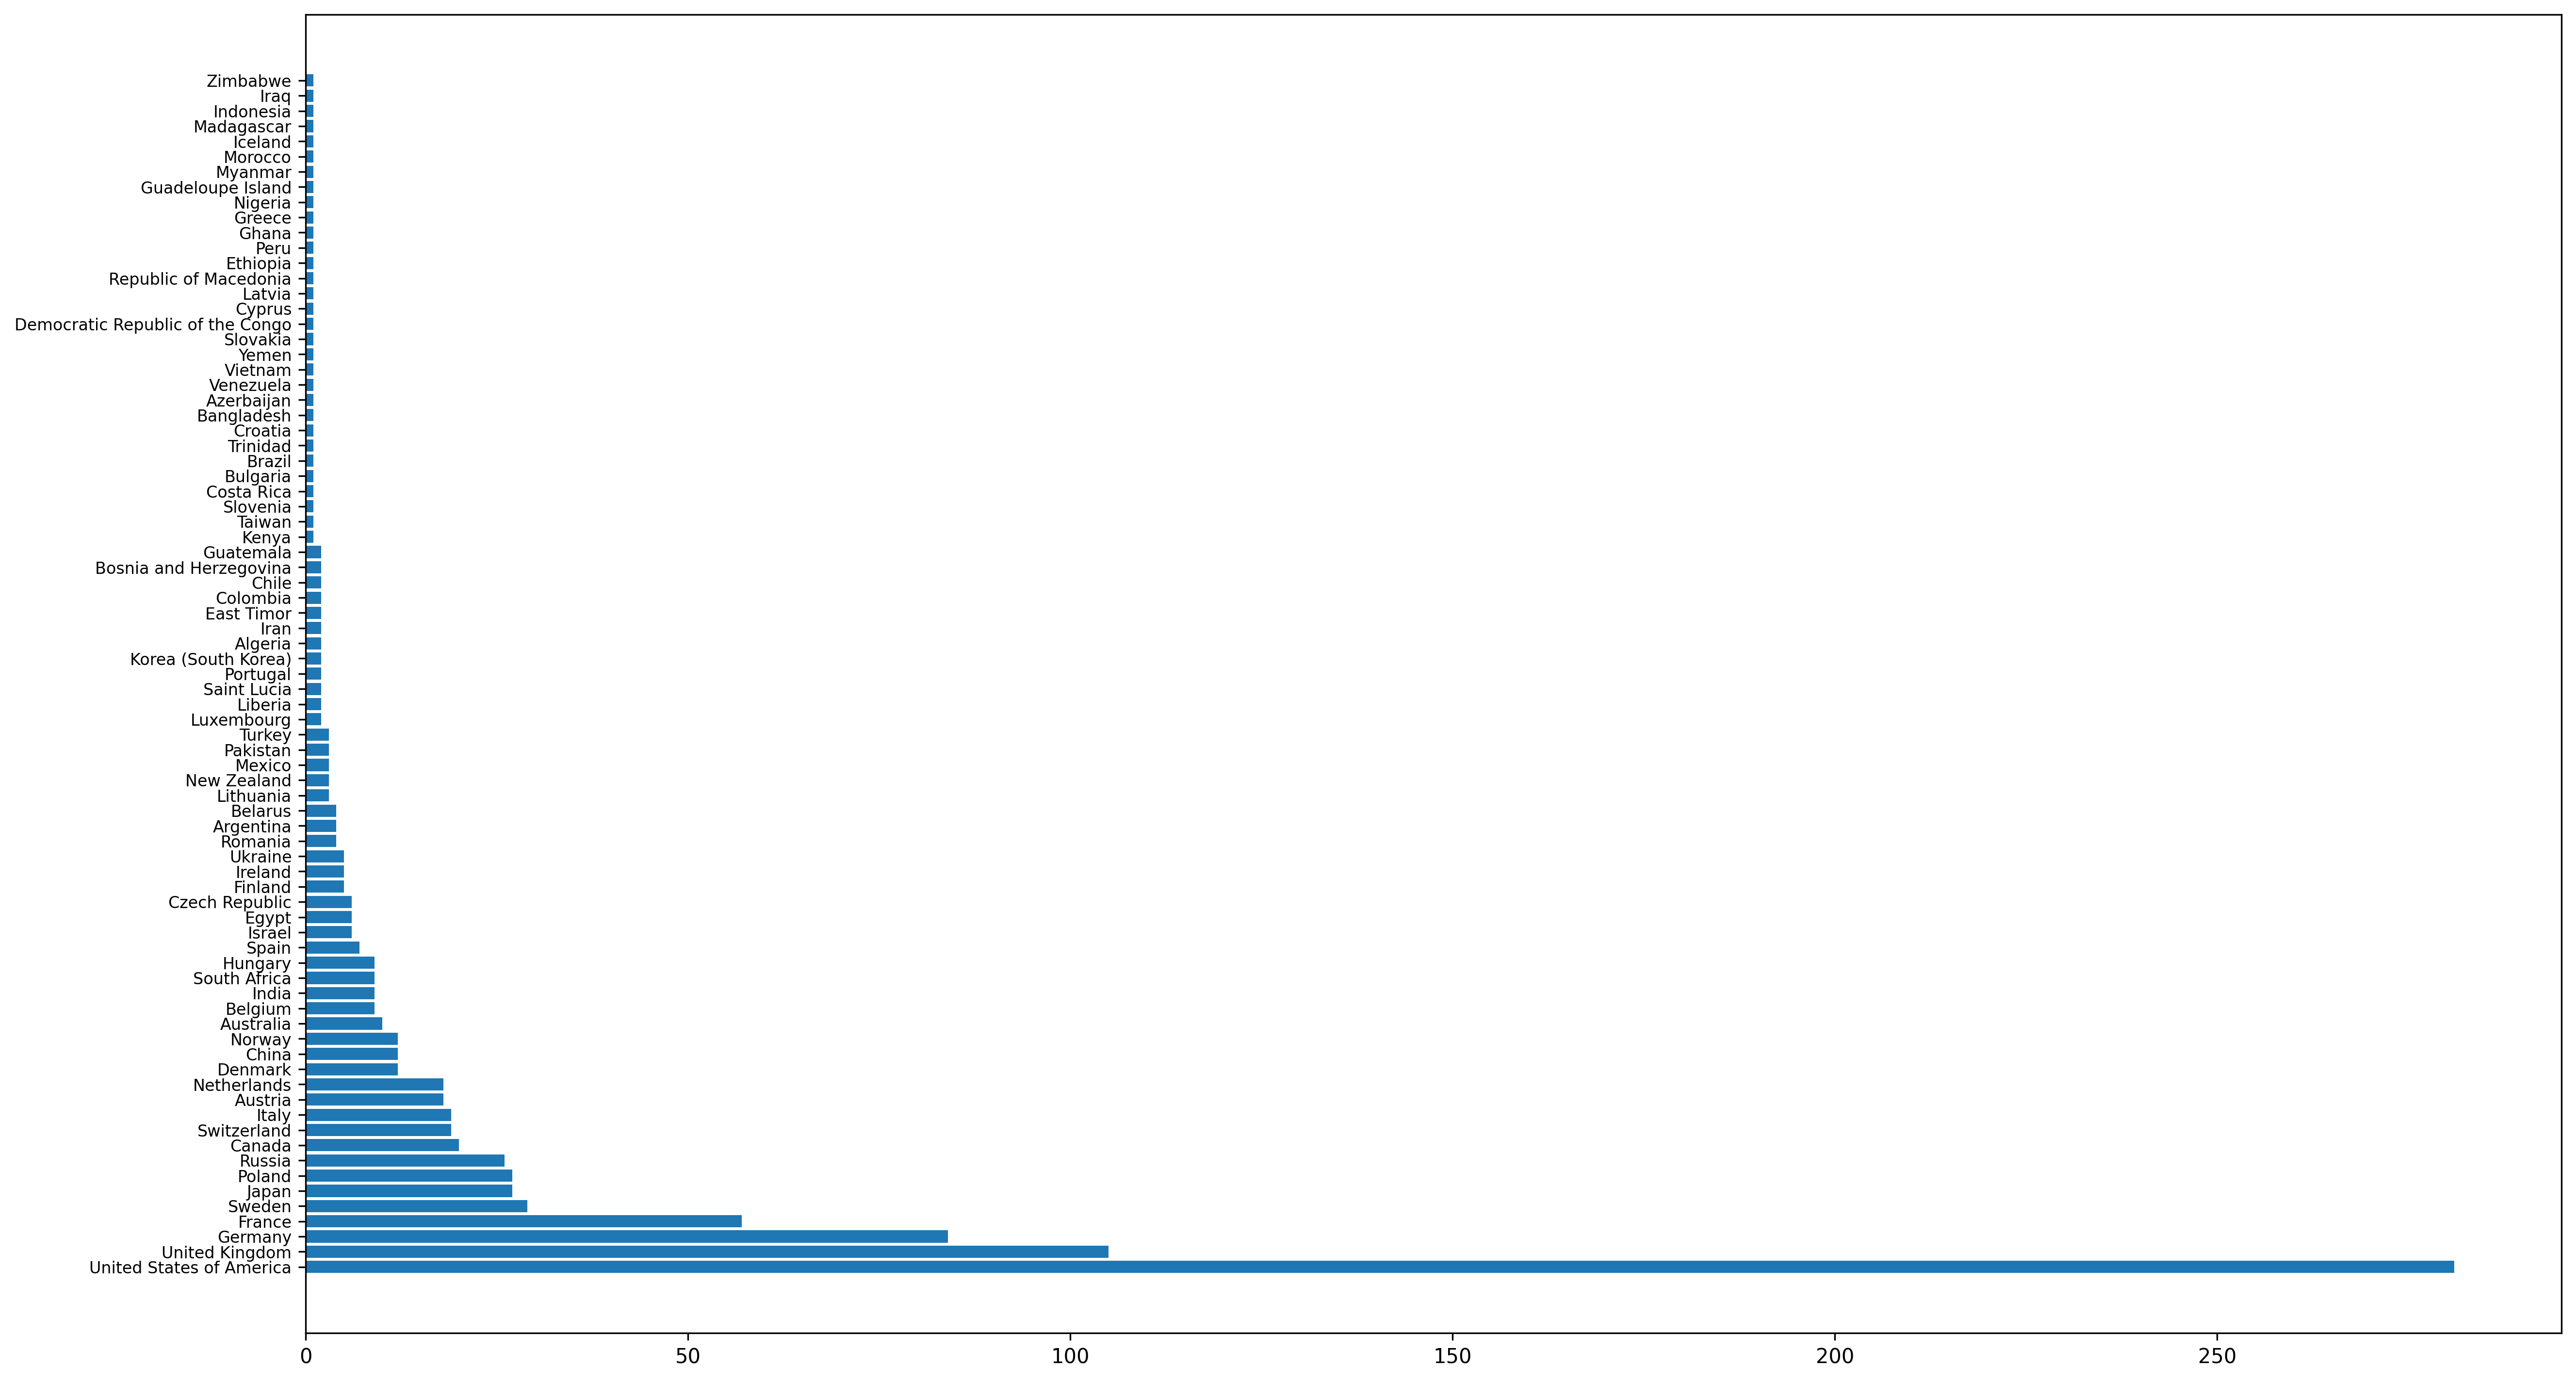

In [85]:
plt.figure(figsize=(20,12), dpi=300)
plt.yticks(fontsize=8)

plt.barh(df_country["birth_country_current"], df_country["prize"])

In [86]:
df_country.head(20)

,birth_country_current,prize
74,United States of America,281
73,United Kingdom,105
26,Germany,84
25,France,57
67,Sweden,29
40,Japan,27
57,Poland,27
61,Russia,26
11,Canada,20
68,Switzerland,19


# Use a Choropleth Map to Show the Number of Prizes Won by Country

* Create this choropleth map using [the plotly documentation](https://plotly.com/python/choropleth-maps/):

<img src=https://i.imgur.com/s4lqYZH.png>

* Experiment with [plotly's available colours](https://plotly.com/python/builtin-colorscales/). I quite like the sequential colour `matter` on this map. 

Hint: You'll need to use a 3 letter country code for each country. 


In [88]:
df_data.head()

,year,category,prize,motivation,prize_share,laureate_type,full_name,birth_date,birth_city,birth_country,birth_country_current,sex,organization_name,organization_city,organization_country,ISO,share_pct
0,1901,Chemistry,The Nobel Prize in Chemistry 1901,"""in recognition of the extraordinary services ...",1/1,Individual,Jacobus Henricus van 't Hoff,1852-08-30,Rotterdam,Netherlands,Netherlands,Male,Berlin University,Berlin,Germany,NLD,100.00
1,1901,Literature,The Nobel Prize in Literature 1901,"""in special recognition of his poetic composit...",1/1,Individual,Sully Prudhomme,1839-03-16,Paris,France,France,Male,NaN,NaN,NaN,FRA,100.00
2,1901,Medicine,The Nobel Prize in Physiology or Medicine 1901,"""for his work on serum therapy, especially its...",1/1,Individual,Emil Adolf von Behring,1854-03-15,Hansdorf (Lawice),Prussia (Poland),Poland,Male,Marburg University,Marburg,Germany,POL,100.00
3,1901,Peace,The Nobel Peace Prize 1901,NaN,1/2,Individual,Frédéric Passy,1822-05-20,Paris,France,France,Male,NaN,NaN,NaN,FRA,50.00
4,1901,Peace,The Nobel Peace Prize 1901,NaN,1/2,Individual,Jean Henry Dunant,1828-05-08,Geneva,Switzerland,Switzerland,Male,NaN,NaN,NaN,CHE,50.00


In [99]:
df_iso = df_data.groupby(['ISO'],
                                as_index=False).agg({'prize': pd.Series.count})
df_iso.sort_values('prize', ascending=False, inplace=True)

df_iso

,ISO,prize
73,USA,281
28,GBR,105
19,DEU,84
27,FRA,57
68,SWE,29
...,...,...
50,LVA,1
51,MAR,1
52,MDG,1
54,MKD,1


In [102]:
choro = px.choropleth(df_iso, locations='ISO', locationmode="ISO-3", color='prize', scope="world")

choro.show()

# In Which Categories are the Different Countries Winning Prizes? 

**Challenge**: See if you can divide up the plotly bar chart you created above to show the which categories made up the total number of prizes. Here's what you're aiming for:

<img src=https://i.imgur.com/iGaIKCL.png>

* In which category are Germany and Japan the weakest compared to the United States?
* In which category does Germany have more prizes than the UK?
* In which categories does France have more prizes than Germany?
* Which category makes up most of Australia's nobel prizes?
* Which category makes up half of the prizes in the Netherlands?
* Does the United States have more prizes in Economics than all of France? What about in Physics or Medicine?


The hard part is preparing the data for this chart! 


*Hint*: Take a two-step approach. The first step is grouping the data by country and category. Then you can create a DataFrame that looks something like this:

<img src=https://i.imgur.com/VKjzKa1.png width=450>


In [107]:
df_country_category = df_data.groupby(['birth_country_current', 'category'],
                                as_index=False).agg({'prize': pd.Series.count})
df_country_category.sort_values('prize', ascending=False, inplace=True)

df_country_category

,birth_country_current,category,prize
204,United States of America,Medicine,78
206,United States of America,Physics,70
201,United States of America,Chemistry,55
202,United States of America,Economics,49
198,United Kingdom,Medicine,28
...,...,...,...
97,Iraq,Peace,1
99,Ireland,Medicine,1
100,Ireland,Physics,1
102,Israel,Economics,1


In [109]:
pivoted_df = pd.pivot(data=df_country_category, index='birth_country_current', columns='category', values='prize')
pivoted_df

category,Chemistry,Economics,Literature,Medicine,Peace,Physics
birth_country_current,,,,,,
Algeria,NaN,NaN,1.00,NaN,NaN,1.00
Argentina,NaN,NaN,NaN,2.00,2.00,NaN
Australia,1.00,NaN,NaN,7.00,NaN,2.00
Austria,5.00,1.00,2.00,6.00,1.00,3.00
Azerbaijan,NaN,NaN,NaN,NaN,NaN,1.00
...,...,...,...,...,...,...
United States of America,55.00,49.00,10.00,78.00,19.00,70.00
Venezuela,NaN,NaN,NaN,1.00,NaN,NaN
Vietnam,NaN,NaN,NaN,NaN,1.00,NaN


In [111]:
pivoted_df = pivoted_df.fillna(0)
pivoted_df

category,Chemistry,Economics,Literature,Medicine,Peace,Physics
birth_country_current,,,,,,
Algeria,0.00,0.00,1.00,0.00,0.00,1.00
Argentina,0.00,0.00,0.00,2.00,2.00,0.00
Australia,1.00,0.00,0.00,7.00,0.00,2.00
Austria,5.00,1.00,2.00,6.00,1.00,3.00
Azerbaijan,0.00,0.00,0.00,0.00,0.00,1.00
...,...,...,...,...,...,...
United States of America,55.00,49.00,10.00,78.00,19.00,70.00
Venezuela,0.00,0.00,0.00,1.00,0.00,0.00
Vietnam,0.00,0.00,0.00,0.00,1.00,0.00


In [127]:
merged_df = pd.merge(df_country, df_country_category, on="birth_country_current")

merged_df.columns = ['birth_country_current', 'total_prize', 'category', 'cat_prize']

merged_df.sort_values(by='total_prize', ascending=False, inplace=True)

merged_df.head(20)

,birth_country_current,total_prize,category,cat_prize
0,United States of America,281,Medicine,78
4,United States of America,281,Peace,19
5,United States of America,281,Literature,10
1,United States of America,281,Physics,70
3,United States of America,281,Economics,49
2,United States of America,281,Chemistry,55
6,United Kingdom,105,Medicine,28
7,United Kingdom,105,Chemistry,27
8,United Kingdom,105,Physics,24
9,United Kingdom,105,Peace,11


In [123]:
cat_cntry_bar = px.bar(x=merged_df.cat_prize,
                       y=merged_df.birth_country_current,
                       color=merged_df['category'],
                       orientation='h',
                       title= 'Top 20 Countries by Number of Prizes and Category')

cat_cntry_bar.update_layout(xaxis_title='Number of Prizes',
                            yaxis_title='Country')

cat_cntry_bar.show()

### Number of Prizes Won by Each Country Over Time

* When did the United States eclipse every other country in terms of the number of prizes won? 
* Which country or countries were leading previously?
* Calculate the cumulative number of prizes won by each country in every year. Again, use the `birth_country_current` of the winner to calculate this. 
* Create a [plotly line chart](https://plotly.com/python/line-charts/) where each country is a coloured line. 

In [128]:
df_data.columns

Index(['year', 'category', 'prize', 'motivation', 'prize_share',
       'laureate_type', 'full_name', 'birth_date', 'birth_city',
       'birth_country', 'birth_country_current', 'sex', 'organization_name',
       'organization_city', 'organization_country', 'ISO', 'share_pct'],
      dtype='object')

In [134]:
df_year = df_data.groupby(['year', 'birth_country_current'],
                                as_index=False).agg({'prize': pd.Series.count})
df_year.sort_values('year', ascending=False, inplace=True)

df_year

,year,birth_country_current,prize
626,2020,United States of America,7
625,2020,United Kingdom,2
624,2020,Germany,1
623,2020,France,1
617,2019,Germany,1
...,...,...,...
3,1901,Poland,1
2,1901,Netherlands,1
1,1901,Germany,1
4,1901,Switzerland,1


In [136]:
pivoted_df = df_year.pivot_table(index='year', columns='birth_country_current', values='prize', aggfunc='sum')
pivoted_df

birth_country_current,Algeria,Argentina,Australia,Austria,Azerbaijan,Bangladesh,Belarus,Belgium,Bosnia and Herzegovina,Brazil,...,Taiwan,Trinidad,Turkey,Ukraine,United Kingdom,United States of America,Venezuela,Vietnam,Yemen,Zimbabwe
year,,,,,,,,,,,,,,,,,,,,,
1901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN,NaN,NaN
1904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.00,NaN,NaN,NaN,NaN,NaN
1905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.00,1.00,NaN,NaN,NaN,NaN
2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.00,6.00,NaN,NaN,NaN,NaN
2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.00,6.00,NaN,NaN,NaN,NaN


In [137]:
pivoted_df = pivoted_df.fillna(0)
pivoted_df

birth_country_current,Algeria,Argentina,Australia,Austria,Azerbaijan,Bangladesh,Belarus,Belgium,Bosnia and Herzegovina,Brazil,...,Taiwan,Trinidad,Turkey,Ukraine,United Kingdom,United States of America,Venezuela,Vietnam,Yemen,Zimbabwe
year,,,,,,,,,,,,,,,,,,,,,
1901,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1902,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1903,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
1904,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00
1905,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,5.00,1.00,0.00,0.00,0.00,0.00
2017,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,6.00,0.00,0.00,0.00,0.00
2018,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,6.00,0.00,0.00,0.00,0.00


In [140]:
pivoted_df = pivoted_df.cumsum()
pivoted_df

birth_country_current,Algeria,Argentina,Australia,Austria,Azerbaijan,Bangladesh,Belarus,Belgium,Bosnia and Herzegovina,Brazil,...,Taiwan,Trinidad,Turkey,Ukraine,United Kingdom,United States of America,Venezuela,Vietnam,Yemen,Zimbabwe
year,,,,,,,,,,,,,,,,,,,,,
1901,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1902,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1903,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
1904,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00
1905,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,2.00,4.00,10.00,17.00,1.00,1.00,4.00,9.00,2.00,1.00,...,1.00,1.00,3.00,5.00,99.00,259.00,1.00,1.00,1.00,1.00
2017,2.00,4.00,10.00,17.00,1.00,1.00,4.00,9.00,2.00,1.00,...,1.00,1.00,3.00,5.00,100.00,265.00,1.00,1.00,1.00,1.00
2018,2.00,4.00,10.00,17.00,1.00,1.00,4.00,9.00,2.00,1.00,...,1.00,1.00,3.00,5.00,101.00,271.00,1.00,1.00,1.00,1.00


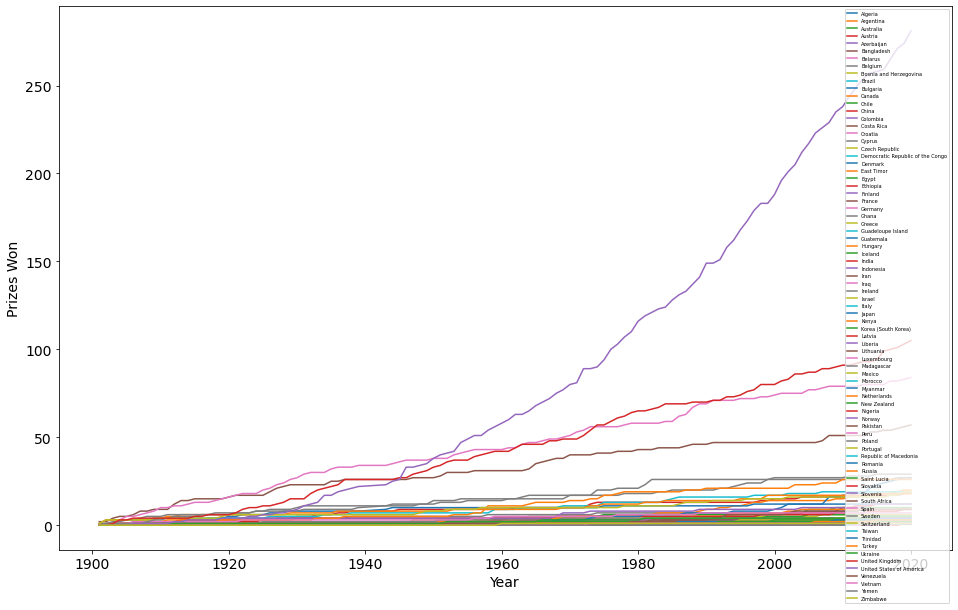

In [141]:
plt.figure(figsize=(16, 10))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Prizes Won', fontsize=14)
plt.plot(pivoted_df.index, pivoted_df)
plt.legend(pivoted_df.columns, fontsize=5)
plt.show()

In [143]:
# l_chart = px.line(pivoted_df,
#                   x='year',
#                   y='prize',
#                   color='birth_country_current',
#                   hover_name="birth_country_current")

# l_chart.update_layout(xaxis_title='Year',
#                       yaxis_title='Number of Prizes')

# l_chart.show()

# What are the Top Research Organisations?

**Challenge**: Create a bar chart showing the organisations affiliated with the Nobel laureates. It should looks something like this:

<img src=https://i.imgur.com/zZihj2p.png width=600>

* Which organisations make up the top 20?
* How many Nobel prize winners are affiliated with the University of Chicago and Harvard University?

In [144]:
df_data.columns

Index(['year', 'category', 'prize', 'motivation', 'prize_share',
       'laureate_type', 'full_name', 'birth_date', 'birth_city',
       'birth_country', 'birth_country_current', 'sex', 'organization_name',
       'organization_city', 'organization_country', 'ISO', 'share_pct'],
      dtype='object')

In [152]:
df_org = df_data.groupby(['organization_name'],
                                as_index=False).agg({'prize': pd.Series.count})
df_org.sort_values('prize', ascending=True, inplace=True)

df_org_20 = df_org[-20:]

df_org_20

,organization_name,prize
79,Institut Pasteur,7
109,London University,7
67,Harvard Medical School,7
192,University College London,7
40,Cornell University,8
12,Bell Laboratories,8
258,Yale University,9
111,MRC Laboratory of Molecular Biology,10
222,University of Oxford,12
152,Rockefeller University,13


In [153]:
org_fig = px.bar(y=df_org_20.organization_name,
                x=df_org_20.prize,
                color=df_org_20.prize, 
                  orientation="h",
                 title="Organizations with the Most Associated Nobel Prizes")

org_fig.update_layout(xaxis_title='Number of Prizes',
                            yaxis_title='Organization')

org_fig.show()

# Which Cities Make the Most Discoveries? 

Where do major discoveries take place?  

**Challenge**: 
* Create another plotly bar chart graphing the top 20 organisation cities of the research institutions associated with a Nobel laureate. 
* Where is the number one hotspot for discoveries in the world?
* Which city in Europe has had the most discoveries?

In [154]:
df_city = df_data.groupby(['organization_city'],
                                as_index=False).agg({'prize': pd.Series.count})
df_city.sort_values('prize', ascending=True, inplace=True)

df_city_20 = df_city[-20:]

df_city_20

,organization_city,prize
65,Göttingen,8
186,Zurich,8
71,Heidelberg,9
119,"New Haven, CT",9
110,Munich,9
23,"Boston, MA",9
108,Moscow,10
157,Stockholm,10
126,Oxford,12
13,Berlin,12


In [155]:
org_fig = px.bar(y=df_city_20.organization_city,
                x=df_city_20.prize,
                color=df_city_20.prize, 
                  orientation="h",
                 title="Cities with the Most Associated Nobel Prizes")

org_fig.update_layout(xaxis_title='Number of Prizes',
                            yaxis_title='City')

org_fig.show()

# Where are Nobel Laureates Born? Chart the Laureate Birth Cities 

**Challenge**: 
* Create a plotly bar chart graphing the top 20 birth cities of Nobel laureates. 
* Use a named colour scale called `Plasma` for the chart.
* What percentage of the United States prizes came from Nobel laureates born in New York? 
* How many Nobel laureates were born in London, Paris and Vienna? 
* Out of the top 5 cities, how many are in the United States?


In [156]:
df_birth_city = df_data.groupby(['birth_city'],
                                as_index=False).agg({'prize': pd.Series.count})
df_birth_city.sort_values('prize', ascending=True, inplace=True)

df_birth_city_20 = df_birth_city[-20:]

df_birth_city_20

,birth_city,prize
343,"Milwaukee, WI",3
87,Cairo,4
356,Montreal,4
428,"Pittsburgh, PA",4
167,Frankfurt-on-the-Main,5
440,Prague,5
515,Stockholm,6
210,Hamburg,6
363,Munich,7
358,Moscow,7


In [157]:
birth_city_fig = px.bar(y=df_birth_city_20.birth_city,
                x=df_birth_city_20.prize,
                color=df_birth_city_20.prize, 
                  orientation="h",
                 title="Cities with the Most Native Nobel Prize Winners")

birth_city_fig.update_layout(xaxis_title='Number of Prizes',
                            yaxis_title='City')

birth_city_fig.show()

# Plotly Sunburst Chart: Combine Country, City, and Organisation

**Challenge**: 

* Create a DataFrame that groups the number of prizes by organisation. 
* Then use the [plotly documentation to create a sunburst chart](https://plotly.com/python/sunburst-charts/)
* Click around in your chart, what do you notice about Germany and France? 


Here's what you're aiming for:

<img src=https://i.imgur.com/cemX4m5.png width=300>



In [159]:
df_org_star = df_data.groupby(['organization_country', 'organization_city', 'organization_name'],
                              as_index=False).agg({'prize': pd.Series.count})

df_org_star = df_org_star.sort_values(by='prize', ascending=False)
df_org_star

,organization_country,organization_city,organization_name,prize
205,United States of America,"Cambridge, MA",Harvard University,29
280,United States of America,"Stanford, CA",Stanford University,23
206,United States of America,"Cambridge, MA",Massachusetts Institute of Technology (MIT),21
209,United States of America,"Chicago, IL",University of Chicago,20
195,United States of America,"Berkeley, CA",University of California,19
...,...,...,...,...
110,Japan,Sapporo,Hokkaido University,1
111,Japan,Tokyo,Asahi Kasei Corporation,1
112,Japan,Tokyo,Kitasato University,1
113,Japan,Tokyo,Tokyo Institute of Technology,1


In [160]:
fig = px.sunburst(df_org_star, path=['organization_country', 'organization_city', 'organization_name'], values='prize')

fig.show()

# Patterns in the Laureate Age at the Time of the Award

How Old Are the Laureates When the Win the Prize?

**Challenge**: Calculate the age of the laureate in the year of the ceremony and add this as a column called `winning_age` to the `df_data` DataFrame. Hint: you can use [this](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.html) to help you. 



In [161]:
df_data.columns

Index(['year', 'category', 'prize', 'motivation', 'prize_share',
       'laureate_type', 'full_name', 'birth_date', 'birth_city',
       'birth_country', 'birth_country_current', 'sex', 'organization_name',
       'organization_city', 'organization_country', 'ISO', 'share_pct'],
      dtype='object')

In [165]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   year                   962 non-null    int64         
 1   category               962 non-null    object        
 2   prize                  962 non-null    object        
 3   motivation             874 non-null    object        
 4   prize_share            962 non-null    object        
 5   laureate_type          962 non-null    object        
 6   full_name              962 non-null    object        
 7   birth_date             934 non-null    datetime64[ns]
 8   birth_city             931 non-null    object        
 9   birth_country          934 non-null    object        
 10  birth_country_current  934 non-null    object        
 11  sex                    934 non-null    object        
 12  organization_name      707 non-null    object        
 13  organ

In [172]:
df_data['winning_age'] = df_data['year'] - pd.DatetimeIndex(df_data['birth_date']).year

In [175]:
df_data['winning_age'].fillna(0)

0     49.00
1     62.00
2     47.00
3     79.00
4     73.00
       ... 
957   71.00
958    0.00
959   55.00
960   68.00
961   89.00
Name: winning_age, Length: 962, dtype: float64

### Who were the oldest and youngest winners?

**Challenge**: 
* What are the names of the youngest and oldest Nobel laureate? 
* What did they win the prize for?
* What is the average age of a winner?
* 75% of laureates are younger than what age when they receive the prize?
* Use Seaborn to [create histogram](https://seaborn.pydata.org/generated/seaborn.histplot.html) to visualise the distribution of laureate age at the time of winning. Experiment with the number of `bins` to see how the visualisation changes.

In [177]:
df_data.sort_values(by='winning_age', ascending=True).head()

,year,category,prize,motivation,prize_share,laureate_type,full_name,birth_date,birth_city,birth_country,birth_country_current,sex,organization_name,organization_city,organization_country,ISO,share_pct,winning_age
885,2014,Peace,The Nobel Peace Prize 2014,"""for their struggle against the suppression of...",1/2,Individual,Malala Yousafzai,1997-07-12,Mingora,Pakistan,Pakistan,Female,NaN,NaN,NaN,PAK,50.00,17.00
85,1915,Physics,The Nobel Prize in Physics 1915,"""for their services in the analysis of crystal...",1/2,Individual,William Lawrence Bragg,1890-03-31,Adelaide,Australia,Australia,Male,Victoria University,Manchester,United Kingdom,AUS,50.00,25.00
932,2018,Peace,The Nobel Peace Prize 2018,“for their efforts to end the use of sexual vi...,1/2,Individual,Nadia Murad,1993-07-02,Kojo,Iraq,Iraq,Female,NaN,NaN,NaN,IRQ,50.00,25.00
305,1957,Physics,The Nobel Prize in Physics 1957,"""for their penetrating investigation of the so...",1/2,Individual,Tsung-Dao (T.D.) Lee,1926-11-24,Shanghai,China,China,Male,Columbia University,"New York, NY",United States of America,CHN,50.00,31.00
171,1933,Physics,The Nobel Prize in Physics 1933,"""for the discovery of new productive forms of ...",1/2,Individual,Paul Adrien Maurice Dirac,1902-08-08,Bristol,United Kingdom,United Kingdom,Male,University of Cambridge,Cambridge,United Kingdom,GBR,50.00,31.00


In [178]:
df_data.sort_values(by='winning_age', ascending=False).head()

,year,category,prize,motivation,prize_share,laureate_type,full_name,birth_date,birth_city,birth_country,birth_country_current,sex,organization_name,organization_city,organization_country,ISO,share_pct,winning_age
937,2019,Chemistry,The Nobel Prize in Chemistry 2019,“for the development of lithium-ion batteries”,1/3,Individual,John Goodenough,1922-07-25,Jena,Germany,Germany,Male,University of Texas,Austin TX,United States of America,DEU,33.33,97.00
933,2018,Physics,The Nobel Prize in Physics 2018,“for the optical tweezers and their applicatio...,1/2,Individual,Arthur Ashkin,1922-09-02,"New York, NY",United States of America,United States of America,Male,Bell Laboratories,"Holmdel, NJ",United States of America,USA,50.00,96.00
794,2007,Economics,The Sveriges Riksbank Prize in Economic Scienc...,"""for having laid the foundations of mechanism ...",1/3,Individual,Leonid Hurwicz,1917-08-21,Moscow,Russia,Russia,Male,University of Minnesota,"Minneapolis, MN",United States of America,RUS,33.33,90.00
961,2020,Physics,The Nobel Prize in Physics 2020,“for the discovery that black hole formation i...,1/2,Individual,Roger Penrose,1931-08-08,Colchester,United Kingdom,United Kingdom,Male,University of Oxford,Oxford,United Kingdom,GBR,50.00,89.00
856,2012,Economics,The Sveriges Riksbank Prize in Economic Scienc...,"""for the theory of stable allocations and the ...",1/2,Individual,Lloyd S. Shapley,1923-06-02,"Cambridge, MA",United States of America,United States of America,Male,University of California,"Los Angeles, CA",United States of America,USA,50.00,89.00


In [180]:
df_data['winning_age'].describe()

count   934.00
mean     59.95
std      12.62
min      17.00
25%      51.00
50%      60.00
75%      69.00
max      97.00
Name: winning_age, dtype: float64

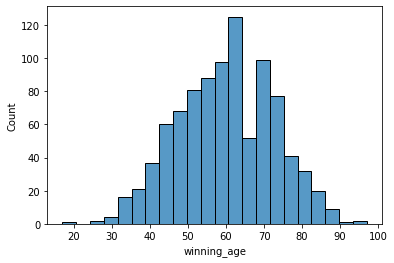

In [183]:
sns.histplot(data=df_data,
             x='winning_age')

### Descriptive Statistics for the Laureate Age at Time of Award

* Calculate the descriptive statistics for the age at the time of the award. 
* Then visualise the distribution in the form of a histogram using [Seaborn's .histplot() function](https://seaborn.pydata.org/generated/seaborn.histplot.html).
* Experiment with the `bin` size. Try 10, 20, 30, and 50.  

In [184]:
df_data['winning_age'].describe()

count   934.00
mean     59.95
std      12.62
min      17.00
25%      51.00
50%      60.00
75%      69.00
max      97.00
Name: winning_age, dtype: float64

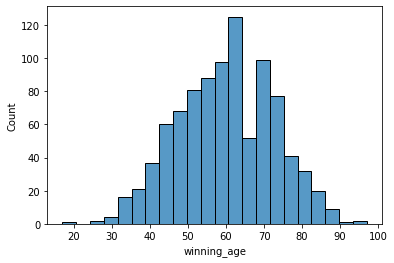

In [185]:
sns.histplot(data=df_data,
             x='winning_age')

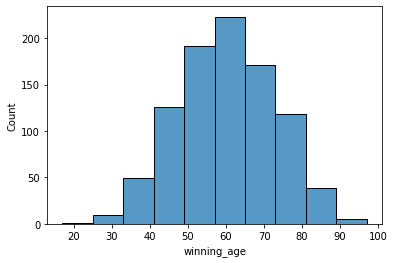

In [186]:
sns.histplot(data=df_data,
             x='winning_age',
             bins=10)

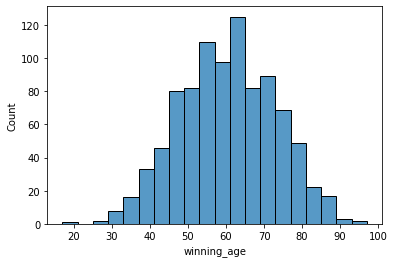

In [187]:
sns.histplot(data=df_data,
             x='winning_age',
             bins=20)

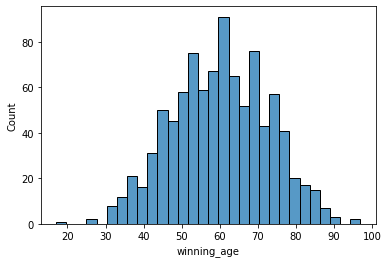

In [188]:
sns.histplot(data=df_data,
             x='winning_age',
             bins=30)

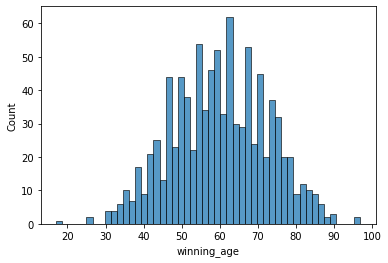

In [189]:
sns.histplot(data=df_data,
             x='winning_age',
             bins=50)

### Age at Time of Award throughout History

Are Nobel laureates being nominated later in life than before? Have the ages of laureates at the time of the award increased or decreased over time?

**Challenge**

* Use Seaborn to [create a .regplot](https://seaborn.pydata.org/generated/seaborn.regplot.html?highlight=regplot#seaborn.regplot) with a trendline.
* Set the `lowess` parameter to `True` to show a moving average of the linear fit.
* According to the best fit line, how old were Nobel laureates in the years 1900-1940 when they were awarded the prize?
* According to the best fit line, what age would it predict for a Nobel laureate in 2020?


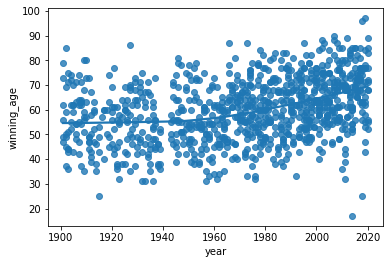

In [191]:
sns.regplot(data=df_data,
            x='year',
            y='winning_age',
            lowess=True)

### Winning Age Across the Nobel Prize Categories

How does the age of laureates vary by category? 

* Use Seaborn's [`.boxplot()`](https://seaborn.pydata.org/generated/seaborn.boxplot.html?highlight=boxplot#seaborn.boxplot) to show how the mean, quartiles, max, and minimum values vary across categories. Which category has the longest "whiskers"? 
* In which prize category are the average winners the oldest?
* In which prize category are the average winners the youngest?

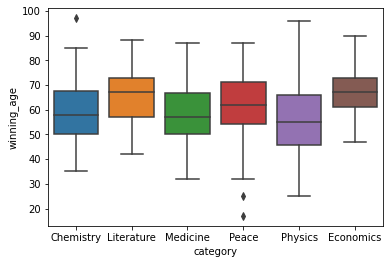

In [192]:
sns.boxplot(data=df_data,
            x='category',
            y='winning_age')

**Challenge**
* Now use Seaborn's [`.lmplot()`](https://seaborn.pydata.org/generated/seaborn.lmplot.html?highlight=lmplot#seaborn.lmplot) and the `row` parameter to create 6 separate charts for each prize category. Again set `lowess` to `True`.
* What are the winning age trends in each category? 
* Which category has the age trending up and which category has the age trending down? 
* Is this `.lmplot()` telling a different story from the `.boxplot()`?
* Create another chart with Seaborn. This time use `.lmplot()` to put all 6 categories on the same chart using the `hue` parameter. 


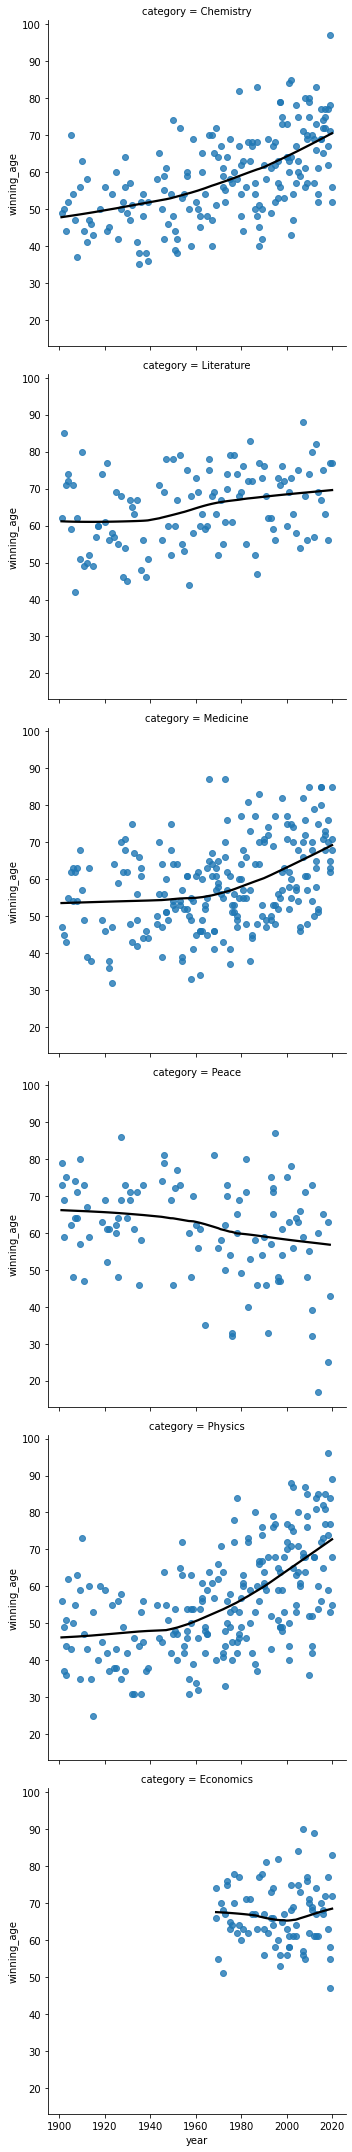

In [196]:
sns.lmplot(data=df_data,
            x='year',
            y='winning_age',
           row='category',
           lowess=True,
           line_kws={'color': 'black'})

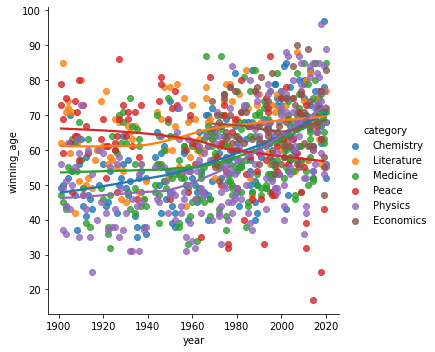

In [194]:
sns.lmplot(data=df_data,
            x='year',
            y='winning_age',
           hue='category',
           lowess=True)